# Анализ рынка компьютерных игр

С помощью информации из открытых источников о компьютерных играх (продажи, рейтинг, оценки пользователей) требуется выявить закономерности, выделяющиее успешные игры, и спланировать рекламный бюджет на следующий год для интернет-магазина игр

### Описание данных

Исторические данные о играх:
- название игры
- платформа
- год выпуска
- жанр игры
- продажи в Северной Америке (миллионы долларов)
- продажи в Европе (миллионы долларов)
- продажи в Японии (миллионы долларов)
- продажи в других странах (миллионы долларов)
- оценка критиков (максимум 100)
- оценка пользователей (максимум 10)
- рейтинг от организации ESRB (англ. Entertainment Software Rating Board)

### Структура проекта

[Шаг 1. Изучение общей информации](#step1)  
[Шаг 2. Подготовка данных](#step2) 
- [Замена названий столбцов](#step2.1) 
- [Обработка пропусков](#step2.2) 
- [Замена типов данных](#step2.3) 
- [Обработка дубликатов](#step2.4)
- [Подсчет суммарных продаж во всех регионах](#step2.5)   

[Шаг 3. Исследовательский анализ данных](#step3)  
[Шаг 4. Составьте портрет пользователя каждого региона](#step4)  
[Шаг 5. Проверка гипотез](#step5)  
[Шаг 6. Общий вывод](#step6)





### <a id="step1">Шаг 1. Изучение общей информации</a>

Напишем функцию для пути файла, чтобы файл открывался и на локальном компьютере, и в практикуме

In [1]:
import os
def try_path(path):
    if os.path.exists(path):
        return path
    else:
        return "." + path

Подключим библиотеки, которые нам потребуются в дальнейшем

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from scipy import stats as st
import re

Создадим dataframe c информаций об играх. Посмотрим 5 случайных записей из него

In [3]:
df = pd.read_csv(try_path('/datasets/games.csv'))
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16097,Wand of Fortune: Mirai e no Prologue Portable,PSP,2010.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
12114,Tomb Raider: Legend,DS,2006.0,Action,0.04,0.02,0.00,0.01,58.0,8,T
2103,Zoo Tycoon DS,DS,2005.0,Strategy,0.86,0.03,0.01,0.08,44.0,6.6,E
7501,Beyblade G-Revolution,GBA,2004.0,Action,0.15,0.05,0.00,0.00,40.0,7.8,E
9504,Momotaro Douchuuki,SAT,1997.0,Misc,0.00,0.00,0.13,0.00,NaN,NaN,NaN


Посмотрим информацию о таблице

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Посмотрим каков процент пропущенных значений для каждого из столбцов

In [5]:
def print_null_values_as_percent(data):
    null_values = data.isnull().sum().sort_values(ascending = False)
    i = 0
    res = pd.DataFrame(columns = ['column', 'missed values'])
    for i in range(len(null_values)):
        if null_values[i] != 0:
            row = len(res)       
            res.loc[row,:] = [null_values.index[i], (round((null_values[i] / len(df))*100, 2)).astype(str)+'%']
    display(res.sort_values('missed values', ascending = False))

print_null_values_as_percent(df)

,column,missed values
0,Critic_Score,51.32%
1,Rating,40.48%
2,User_Score,40.09%
3,Year_of_Release,1.61%
4,Genre,0.01%
5,Name,0.01%


Посмотрим описательные статистики, чтобы посмотреть каковы границы значений и проверить нет ли у нас явно ложных значений 

In [6]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Посмотрим уникальные значения для данных, представленных типом object

In [7]:
object_df = df.select_dtypes(include = 'object')
for col in object_df:
    print(object_df[col].value_counts().sort_values(ascending = False))
    print()

Need for Speed: Most Wanted    12
Madden NFL 07                   9
Ratatouille                     9
FIFA 14                         9
LEGO Marvel Super Heroes        9
                               ..
Wild ARMs 3                     1
Shining Hearts                  1
Battlefield 2142                1
GunGriffon: Allied Strike       1
Storm Lover Kai!!               1
Name: Name, Length: 11559, dtype: int64

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       29
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: Platform, dtype: int64

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platf

### Вывод

Посмотрели общую информацию о данных. Объем данных - 16 714 записей. 

Выявили следующие пропуски:
- Примерно у половины нет оценки критиков и у чуть менее чем половины нет оценки пользователей. Вероятная причина таких пропусков - эти оценки не были проставлены критиками и пользователями.
- В 40% записей нет рейтинга ESRB. Предположительно, эти игры не были оценены ESRB
- Менее чем у 2% игр не заполнен год выпуска. Можем предположить, что в источниках не был указан год 
- У 0.01% игр не заполнено имя и жанр. Так как пропущено одинаковое количество записей с именем и жанром, предположительно, это одни и те же игры. Возможно, был какой-то сбой при выгрузке и имя, и жанр не попали к нам в таблицу.
- У 2424 записей поле оценка заполено как "tbd". TBD расшифровывается как to be defined. Скорее всего игру оценивают много пользователей и значение в колонке user_score - среднее из их оценок. Можем предположить, что значение tbd значит, что игру оценили очень мало пользователей и мы ждем большего количества оценок, чтобы сделать вывод как в среднем оценивают игру пользователи.

Обнаружили, что в столбцах Year_of_Release, critic_score из-за того что там есть пропуски в данных,  хранятся float значения, хотя нам было бы достаточно целого числа. В user_score хранятся числа как строки, т.к. одно из значений 'tbd'.Выполним преобразование типов для валидных значений в одном из следующих шагов.

Увидели, что в названии столбцов использованы хаотично оба регистра, с такими названиями будет неудобно работать в дальнейшем. Нужно будет привести их к нижнему регистру.

Посмотрим, что значит каждое из обозначений в рейтинге ESRB. В дальнейшем нам это может пригодится:  
E (Everyone) — «Для всех 6+  
T (Teen) — «Подросткам» 13+  
M (Mature) — «Для взрослых» 17+  
E10+ (Everyone 10 and older) — «Для всех от 10 лет и старше» 10+  
EC («Early childhood») — «Для детей младшего возраста»: 3+  
K-A ("Kids to Adults") старое название для категории E - everyone 6+  
RP («Rating Pending») — «Рейтинг ожидается»  
AO («Adults Only 18+») — «Только для взрослых» 18+

Видно, что K-A - старое название для категории E. Нужно будет перименовать категорию K-A в E.

### <a id="step2">Шаг 2. Подготовка данных</a>

- ### <a id="step2.1">Замена названий столбцов</a>

Приведем к нижнему регистру названия столбцов

In [8]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

- ### <a id="step2.2">Обработка пропусков</a>

Посмотрим еще раз сколько у нас пропущенных значений в каждом из столбцов

In [9]:
print_null_values_as_percent(df)

,column,missed values
0,critic_score,51.32%
1,rating,40.48%
2,user_score,40.09%
3,year_of_release,1.61%
4,genre,0.01%
5,name,0.01%


<b>- critic_score - 51% пропусков</b>

51% пропущенных записей с оценкой критиков. Предположительно, оценка критиков не будет сильно отличаться для одной и той же игры на разных платформах. Проверим, есть ли у нас информация об оценке критиков для пропущеных значений для других платформ

In [10]:
score_not_null_names = df.query('critic_score.notnull()')['name']
df.query('critic_score.isnull() and name in @score_not_null_names')['name'].count()

961

У нас есть информация для 961 игры. Произведем замену на наиболее встречаемые значения по названию игры.

In [11]:
def mode_critic_score(data):
    if(any(data.isnull()) and not(all(data.isnull()))): # есть null в группе и не все значения null
        mode = data.mode()
        df.loc[(df['critic_score'].isnull()) & (df['name'] == data.name),'critic_score'] = mode[0]

df.groupby('name')['critic_score'].apply(mode_critic_score)

name
 Beyblade Burst                 None
 Fire Emblem Fates              None
 Frozen: Olaf's Quest           None
 Haikyu!! Cross Team Match!     None
 Tales of Xillia 2              None
                                ... 
thinkSMART: Chess for Kids      None
uDraw Studio                    None
uDraw Studio: Instant Artist    None
wwe Smackdown vs. Raw 2006      None
¡Shin Chan Flipa en colores!    None
Name: critic_score, Length: 11559, dtype: object

Посмотрим каков стал процент пропущенных значений после замены

In [12]:
round(df['critic_score'].isnull().sum()/len(df) * 100)

46.0

Произвели замену на моду у 5% записей

<b>- rating - 40% пропусков</b>

Возрастная категория показывает с какого возраста можно играть в игру. Возможно, у некоторых игр будет оценка для одной платформы, но не будет оценки - для другой. Если есть такие игры, то заменим пропуски на максимальный возраст соответственно рейтингу, с какого можно играть в эту игру, для других платформ. Сначала проверим есть ли такие игры,

In [13]:
rating_null_names = df.query('rating.isnull()')['name']
df.query('rating.notnull() and name in @rating_null_names')['name'].count()

680

Перименуем категорию K-A в E, т.к. K-A ("Kids to Adults") старое название для категории E - everyone 6+

In [14]:
df['rating'].replace('K-A','E', inplace = True)
df.query('rating == "K-A"')['rating'].count()

0

Добавим колонку которая будет содержать минимальный возраст, с которого можно играть в игру, согласно рейтингу ESRB:  
E (Everyone) — «Для всех 6+  
T (Teen) — «Подросткам» 13+  
M (Mature) — «Для взрослых» 17+  
E10+ (Everyone 10 and older) — «Для всех от 10 лет и старше» 10+  
EC («Early childhood») — «Для детей младшего возраста»: 3+  
RP («Rating Pending») — «Рейтинг ожидается»  
AO («Adults Only 18+») — «Только для взрослых» 18+

In [15]:
dict_rating_age = ({'E':6,'T':13,'M':17,'E10+':10,'EC':3,'AO':18})
df['rating_min_age'] = df['rating'].map(dict_rating_age)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_min_age
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,6.0
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,6.0
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,6.0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,NaN


Произведем замену rating_min_age на наибольший по названию игры

In [16]:
df['rating_min_age'] = df.groupby('name')['rating_min_age'].apply(lambda x: x.fillna(x.loc[x.isnull() == False].max()))

Заполним значений пропущенного рейтинга в соответствии с минимальным возрастом, с которого можно играть в игру

In [17]:
dict_age_rating ={}
for k, v in dict_rating_age.items():
    dict_age_rating[v] = k

dict_age_rating
df['rating'] = df['rating_min_age'].map(dict_age_rating)

Посмотрим каков процент пропусков, который удалось так заменить

In [18]:
round(df['rating'].isnull().sum()/len(df) * 100)

38.0

Заменили 2% пропусков в рейтинге на максимальный рейтинг по возрасту по имени игры

<b>- user_score - 40% пропусков</b>

Предположительно tbd - это означает, что слишком мало пользователей оценили игру и мы не можем сделать вывод о средней оценке пользователей игры. Для нас это означает, что мы не знаем оценку как и в случае с null. Заменим значения tbd на null, т.к. нам не важен факт того, что пользователи ее заполняли, а важна сама оценка, а ее нет

In [19]:
df['user_score'].replace('tbd',np.NaN, inplace = True)
df.query('user_score == "tbd"')['user_score'].count()

0

Посмотрим каков стал процент пропусков после такой замены

In [20]:
round(df['user_score'].isnull().sum()/len(df) * 100)

55.0

Как и в случае с критиками предположим, что оценка пользователей не будет сильно отличаться для одной и той же игры на разных платформах. Произведем замену пропусков на наиболее встречаемые значения по имени игры.

In [21]:
def mode_user_score(data):
    if(any(data.isnull()) and not(all(data.isnull()))): # есть null в группе и не все значения null
        mode = data.mode()
        df.loc[(df['user_score'].isnull()) & (df['name'] == data.name),'user_score'] = mode[0]

df.groupby('name')['user_score'].apply(mode_user_score)

name
 Beyblade Burst                 None
 Fire Emblem Fates              None
 Frozen: Olaf's Quest           None
 Haikyu!! Cross Team Match!     None
 Tales of Xillia 2              None
                                ... 
thinkSMART: Chess for Kids      None
uDraw Studio                    None
uDraw Studio: Instant Artist    None
wwe Smackdown vs. Raw 2006      None
¡Shin Chan Flipa en colores!    None
Name: user_score, Length: 11559, dtype: object

Посмотрим каков стал процент пропусков после замены пропусков

In [22]:
round(df['user_score'].isnull().sum()/len(df) * 100)

48.0

Произвели замену на моду у 7% записей

<b>- year_of_release - 1.61%</b>

Год выпуска для одинаковых игр на разных платформ обычно одинаков или отличается не сильно. Посмотрим знаем ли мы информацию о годе выпуска для игр с пропущенных годом для других платформ.

In [23]:
year_null_names = df.query('year_of_release.isnull()')['name']
df.query('year_of_release.notnull() and name in @year_null_names')['name'].count()

204

Произведем замену на самый часто встречающийся год в играх с тем же именем на других платформах

In [24]:
def mode_year_of_release(data):
    if(any(data.isnull()) and not(all(data.isnull()))): # есть null в группе и не все значения null
        mode = data.mode()
        df.loc[(df['year_of_release'].isnull()) & (df['name'] == data.name),'year_of_release'] = mode[0]

df.groupby('name')['year_of_release'].apply(mode_year_of_release)

name
 Beyblade Burst                 None
 Fire Emblem Fates              None
 Frozen: Olaf's Quest           None
 Haikyu!! Cross Team Match!     None
 Tales of Xillia 2              None
                                ... 
thinkSMART: Chess for Kids      None
uDraw Studio                    None
uDraw Studio: Instant Artist    None
wwe Smackdown vs. Raw 2006      None
¡Shin Chan Flipa en colores!    None
Name: year_of_release, Length: 11559, dtype: object

Посмотрим каков стал процент пропусков после замены

In [25]:
round(df['year_of_release'].isnull().sum()/len(df) * 100,2)

0.87

Процент пропусков стал меньше 1%

<b>- genre и name - 0.01% пропусков</b>

Посмотрим одни и те же ли записи - пропуски с жанром и и именем игры

In [26]:
df.query('genre.isnull() and name.notnull()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_min_age


Пропуски сделаны в одних и тех же строках. Посмотрим, что это за записи

In [27]:
df.query('genre.isnull()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_min_age
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,NaN


Это игры за 1993 год, очень маловероятно, что они повлияют на нашу кампанию на 2017г и их всего 2. Удалим эти записи

In [28]:
df.dropna(subset = ['genre'], inplace = True) 

Посмотрим сколько у нас стало пропущенных значений после замен

In [29]:
print_null_values_as_percent(df)

,column,missed values
0,user_score,48.01%
1,critic_score,45.56%
2,rating_min_age,37.87%
3,rating,37.87%
4,year_of_release,0.87%


### Вывод

- Заменили пропушенные значения в оценке пользователей и критиков на моду по имени игры, т.к. предположили, что оценка не будет сильно отличаться для одной и той же игры для разных платформ. Удалось произвести такую замену пропусков у небольшого количества записей(7% - user_score, 5% - critic_score), у многих игр не было оценки ни для одной из платформ. Предположили, что значения tbd в пользовательской оценке означет, что слишком мало пользователей оценили игру, чтобы сделать вывод о пользоватееской оценке. Обработали их так же как и null значения. Вероятная причина появления пропусков - критики и пользователи не оставили оценку у этих игр. После замены осталось 48% пропусков в пользовательской оценке и 46% в оценке критиков 
- Пропуски в рейтинге заменили на максимальный рейтинг по возрасту для игр с таким же именем на других плафтормах. Удалось заменить малый процент записей. Осталось 38% пропусков в этих данных
- Пропуски в годе выпуска заменили на наиболее часто встречающийся год по имени игры. Решили, что одинаковые игры на разных платформах выпускаются примерно в один год. Предположили, что в источниках не был указан год выпуска. Осталось около 1% пропусков в годе выпуска
- Записи с пропусками в жанре и имени игры оказались две игры за 1993 год. Решили, т.к. данных очень мало и это данные за 1993 год, то они вряд ли нам пригодятся при планировании кампании за 2017 год. Удалили записи с пропусками в имени и жанре игры. Предположительная причина появления пропусков - сбой при выгрузке и имя, и жанр не попали к нам в таблицу

- ### <a id="step2.3">Замена типов данных</a>

Произведем замену значений critic_score, year_of_release на целые числа, там где нет пропусков

In [30]:
cols = ['year_of_release', 'critic_score']
for col in cols:
    df[col] = df[col].astype('Int64')
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_min_age
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8,E,6.0
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,6.0
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8,E,6.0
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN,NaN


Приведем значения пользовательской оценки к числу с плавающей точки вместо строки. Мы можем это теперь сделать, т.к. произвели замену tbd на null в предыдущем шаге

In [31]:
df['user_score'] = df['user_score'].astype('float')

Посмотрим какие значения типов теперь в таблице после наших изменений

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16567 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     9098 non-null   Int64  
 9   user_score       8689 non-null   float64
 10  rating           10384 non-null  object 
 11  rating_min_age   10384 non-null  float64
dtypes: Int64(2), float64(6), object(4)
memory usage: 1.7+ MB


### Вывод

 - Привели значения critic_score, year_of_release к целому числу, там где нет пропусков, т.к. год - целое число и оценку критики выставляют как целое число
 - Привели значения user_score к числу с плавающей точкой, т.к. оценка пользователей скорее всего представлена средним значением по оценкам большого количества людей

- ### <a id="step2.4">Обработка дубликатов</a>

Проверим есть ли дубли в данных. Индексом для поиска дублей будем считать сочетание имени, платформы и года выпуска

In [33]:
df.duplicated(['name','platform','year_of_release']).sum()

2

Нашлось два дубликата. Посмотрим в каких играх произошло задвоение

In [34]:
df[df.duplicated(['name','platform','year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_min_age
4127,Sonic the Hedgehog,PS3,2006,Platform,0.0,0.48,0.0,0.0,43,4.1,E10+,10.0
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,83,5.5,E,6.0


Найдем дубли для этих игр

In [35]:
dublicates = df.query('(name == "Madden NFL 13" or name == "Sonic the Hedgehog")  and platform == "PS3"')
dublicates.index

Int64Index([604, 1745, 4127, 16230], dtype='int64')

Записи отличаются только продажами. Предположим, что у нас данные выгружаются из разных источников и преобразуются в процессе (например, из разных магазинов). Тогда нам нужно преобразовать дубли в одну записи просуммировав продажи.Создадим сводную таблицу с суммой по продажам

In [36]:
cols = ['genre','critic_score', 'user_score', 'rating','rating_min_age']
dublicates_pivot = dublicates.pivot_table(index = ['name','platform','year_of_release'], values = ['na_sales', 'jp_sales','eu_sales','other_sales'], aggfunc = 'sum')#.reset_index()
dublicates_pivot

,,,eu_sales,jp_sales,na_sales,other_sales
name,platform,year_of_release,,,,
Madden NFL 13,PS3,2012,0.23,0.00,2.11,0.23
Sonic the Hedgehog,PS3,2006,0.54,0.04,0.41,0.66


Заменим значения по продажам в исходном датафрейме на значения из сводной табицы. 

In [37]:
for row in dublicates_pivot.iterrows():
    name = row[0][0]
    platform = row[0][1]
    year = row[0][2]
    eu_sales = row[1][0]
    jp_sales = row[1][1]
    na_sales = row[1][2]
    other_sales = row[1][3]
    df.loc[(df['name'] == name) & (df['platform'] == platform) & (df['year_of_release'] == year), 'jp_sales'] = jp_sales
    df.loc[(df['name'] == name) & (df['platform'] == platform) & (df['year_of_release'] == year), 'na_sales'] = na_sales
    df.loc[(df['name'] == name) & (df['platform'] == platform) & (df['year_of_release'] == year), 'eu_sales'] = eu_sales
    df.loc[(df['name'] == name) & (df['platform'] == platform) & (df['year_of_release'] == year), 'other_sales'] = other_sales  

Удалим дубликаты

In [38]:
df.drop_duplicates(['name','platform','year_of_release'], inplace = True)
df.duplicated(['name','platform','year_of_release']).sum()

0

In [39]:
df.query('(name == "Madden NFL 13" or name == "Sonic the Hedgehog")  and platform == "PS3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_min_age
604,Madden NFL 13,PS3,2012,Sports,2.11,0.23,0.00,0.23,83,5.5,E,6.0
1745,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.54,0.04,0.66,43,4.1,E10+,10.0


### Вывод

Нашли два дубликата для игр Madden NFL 13,Sonic the Hedgehog для платформы PS3 . Записи отличались только продажами. Предположили, что у нас данные выгружаются из разных источников и преобразуются в процессе (например, из разных магазинов). Преобразовали дубли в одну запись для каждой из игр, просуммировав продажи

- ### <a id="step2.5">Подсчет суммарных продаж во всех регионах</a>

Добавим в данные столбец total_sales с суммарными продажами во всех регионах

In [40]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_min_age,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,6.0,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,6.0,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,6.0,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN,NaN,31.38


### <a id="step3">Шаг 3. Исследовательский анализ данных</a>

- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?


Построим график, показывающий количество выпущенных игр по годам

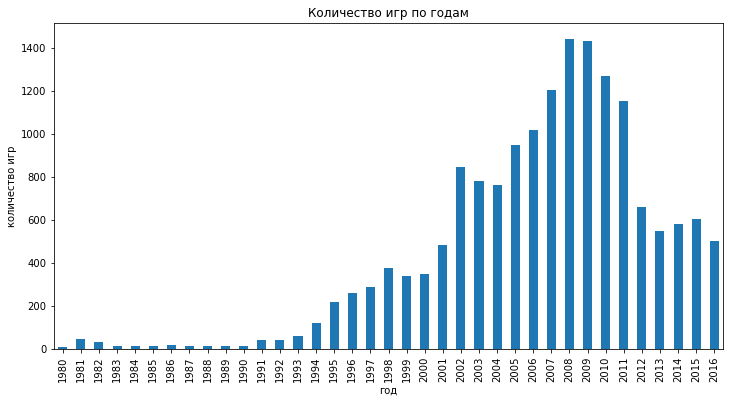

In [41]:
games_qty_by_year = df['year_of_release'].value_counts()
ax = games_qty_by_year.sort_index().plot(kind ='bar',figsize = (12,6), title = 'Количество игр по годам');
ax.set_xlabel('год');
ax.set_ylabel('количество игр');

По графику видно, что основное количество игр продаются те, которые были выпущены после 2001 года. Будем рассматривать только их в дальнейшем

- Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

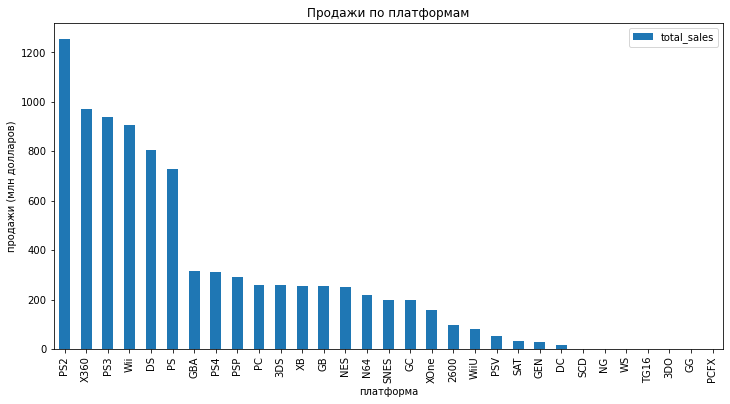

In [42]:
sales_by_platform = df.pivot_table(index = 'platform', values=  'total_sales', aggfunc = 'sum')
ax = sales_by_platform.sort_values('total_sales', ascending = False).plot(kind ='bar',figsize = (12,6), title = 'Продажи по платформам');
ax.set_xlabel('платформа');
ax.set_ylabel('продажи (млн долларов)');

По графику выше видно, что после платформы PS идет спад в продажах. Будем считать платформами с максимальными продажами: все до PS на графике, можем задать условие - общие продажи до 400 млн долларов. Сформируем датасет max_sales_platforms с платформами, которые входят в топ продаж

In [43]:
max_sales_platforms = sales_by_platform.query('total_sales > 400').index
max_sales_platforms

Index(['DS', 'PS', 'PS2', 'PS3', 'Wii', 'X360'], dtype='object', name='platform')

Посмотрим в каких годах выпускались игры на популярных платформах

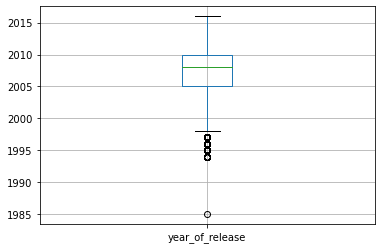

In [44]:
df.query('platform in @max_sales_platforms').boxplot(column = 'year_of_release');

Посмотрим график распределения продаж на каждой из платформ по годам. 1985 год яляется явным выбросом, не будем учитывать его в анализе

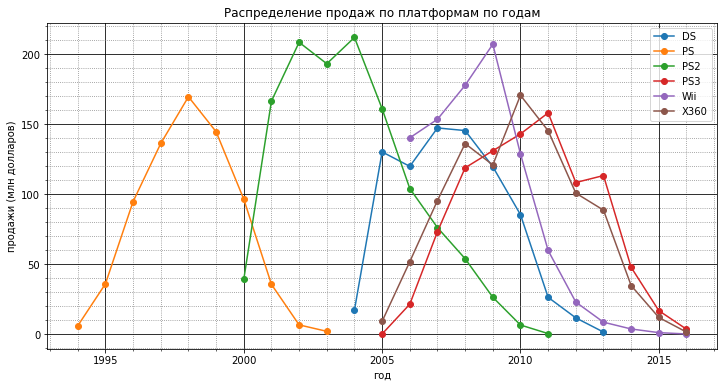

In [45]:
import matplotlib.ticker as ticker
i = 0

for platform in max_sales_platforms:
    sales_by_platform = df.query('platform == @platform and year_of_release > 1985').pivot_table(index = 'year_of_release', values=  'total_sales', aggfunc = 'sum')
    sales_by_platform
    if i == 0:
        axes = sales_by_platform.plot(kind ='line',style = 'o-', figsize = (12,6), title = 'Распределение продаж по платформам по годам');
    else:
        sales_by_platform.plot(kind ='line', figsize = (12,6), style = 'o-',ax = axes, grid = True);    
    i += 1
axes.set_xlabel('год');
axes.set_ylabel('продажи (млн долларов)');
axes.legend(max_sales_platforms);


#  Устанавливаем интервал основных и
#  вспомогательных делений:
axes.xaxis.set_major_locator(ticker.MultipleLocator(5))
axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))
axes.yaxis.set_major_locator(ticker.MultipleLocator(50))
axes.yaxis.set_minor_locator(ticker.MultipleLocator(10))


#  Добавляем линии основной сетки:
axes.grid(which='major',
        color = 'k')

#  Включаем видимость вспомогательных делений:
axes.minorticks_on()
#  Теперь можем отдельно задавать внешний вид
#  вспомогательной сетки:
axes.grid(which='minor',
        color = 'gray',
        linestyle = ':')


По графику можно увидеть срок смены платформы на другую платформу для каждой из платформ. Построим датафрейм, ориентируясь на график, содержащий "время процветания" каждой из платформ. Появлением новой платформы будем считать момент, когда ее продажи выше чем продажи предыдущей платформы. 

In [46]:
paltforms_life_cycle = pd.DataFrame(columns = ['platform','years'], data = [['PS',6], ['PS2',5], ['PS3',5], ['Wii',4]])
paltforms_life_cycle['years'].mean()

5.0

Характерное время смены одной платформы на другую - 5 лет

- Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

На прошлых шагах мы выяснили, что самые продаваемые игры с годом выпуска больше 2001 и среднее время смены одной платформы на другую 5 лет. Из этого можно сделать вывод, что нам достаточно взять данные для анализа -5 лет, т.е. с 2011 года

In [47]:
df_actual = df.query('year_of_release >= 2011')


- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.


Сгруппируем наши актуальные данные по платформам и годам. Посчитаем суммарные продажи. Поставим в соотвествие каждой платформе и году - ранг насколько игры были продаваемы. Получим турнирную таблицу популярности игр по годам

In [48]:
actual_sales_by_platform = df_actual.pivot_table(index = 'year_of_release', columns = 'platform',values=  'total_sales', aggfunc = 'sum').T
ranks = actual_sales_by_platform.rank(ascending=False)

ranks

year_of_release,2011,2012,2013,2014,2015,2016
platform,,,,,,
3DS,3.0,3.0,3.0,4.0,3.0,3.0
DS,6.0,8.0,11.0,NaN,NaN,NaN
PC,5.0,4.0,7.0,7.0,7.0,4.0
PS2,9.0,NaN,NaN,NaN,NaN,NaN
PS3,1.0,1.0,1.0,3.0,4.0,7.0
PS4,NaN,NaN,4.0,1.0,1.0,1.0
PSP,7.0,9.0,10.0,10.0,10.0,NaN
PSV,8.0,7.0,8.0,8.0,8.0,6.0
Wii,4.0,5.0,9.0,9.0,9.0,9.0


Посмотрим топ-3 платформ по продажам за эти годы

In [49]:
top_3 = ranks <= 3
top_3 = top_3.reset_index()
top_3.replace(False,np.nan,inplace = True)
top_3 = top_3.set_index('platform')
top_3.dropna(inplace = True, how = 'all')
top_3

year_of_release,2011,2012,2013,2014,2015,2016
platform,,,,,,
3DS,1.0,1.0,1.0,NaN,1.0,1.0
PS3,1.0,1.0,1.0,1.0,NaN,NaN
PS4,NaN,NaN,NaN,1.0,1.0,1.0
X360,1.0,1.0,1.0,NaN,NaN,NaN
XOne,NaN,NaN,NaN,1.0,1.0,1.0


По продажам в последние годы лидируют платформы 3DS, PS4, XOne

Добавим в эту таблицу поле is_growing True/False/None в зависимости от того растут продажи или нет

In [50]:
def is_growing(row):
    row = row.sort_index(ascending = False)
    last_value = row.iloc[0]
    res = True
    if last_value != last_value: #если данные за 2016г null вернем null
        return last_value
    eq_val = 0
    for i in range(1,len(row) - 1): #идем последовательно от 2015 до 2011г
        if row.iloc[i] > last_value: #нашли значение больше значения за 2016г
            return False
        elif row.iloc[i] == last_value: #значения совпадают
            if eq_val == 1:
                return np.nan
            res = False
            eq_val = 1
        else:
            res = True
    return res   

ranks['is_growing'] = ranks.apply(is_growing, axis = 1)

Посмотрим продажи по каким платформам растут, а по каким - падают

In [51]:
display(ranks.query('is_growing == True'))
display(ranks.query('is_growing == False'))

year_of_release,2011,2012,2013,2014,2015,2016,is_growing
platform,,,,,,,
PS3,1.0,1.0,1.0,3.0,4.0,7.0,True
X360,2.0,2.0,2.0,5.0,6.0,8.0,True


year_of_release,2011,2012,2013,2014,2015,2016,is_growing
platform,,,,,,,
3DS,3.0,3.0,3.0,4.0,3.0,3.0,False
PC,5.0,4.0,7.0,7.0,7.0,4.0,False
PSV,8.0,7.0,8.0,8.0,8.0,6.0,False
WiiU,NaN,6.0,5.0,6.0,5.0,5.0,False


Узнали, что продажи по платформам PS3, X360 растут, а по платформам - 3DS, PC,PSV,  WiiU, - падают. При этом они падают меньше 4 лет, так что в следующим году эти платформы скорее всего будут еще актуальны

- Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.


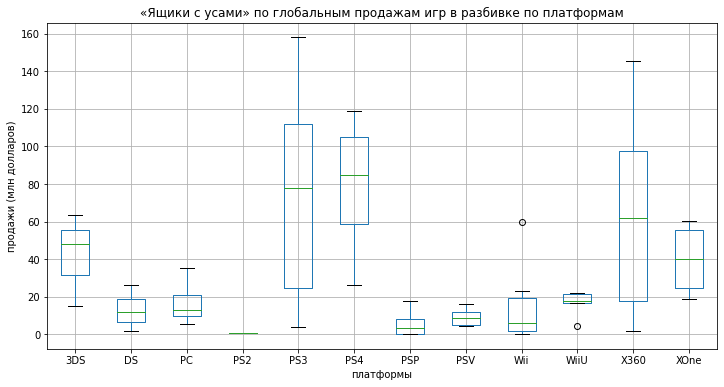

In [52]:
ax = actual_sales_by_platform.T.plot(kind = 'box', figsize = (12,6), grid = True, title = '«Ящики с усами» по глобальным продажам игр в разбивке по платформам');
ax.set_ylabel('продажи (млн долларов)');
ax.set_xlabel('платформы');

Самые высокая медиана по продажам у платформы PS4, самая низкая - у PS2. У платформы Wii есть выброс сверху, у платфомы WiiU - выброс снизу. Выброс значит, что в какйо-то год купили игр на этой платформе нетипично больше/меньше. Самый большой разброс значений по продажам у платформы PS3, самый низкий - PS2

- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.


Расммотрим вопросы выше на примере плафтормы PS4

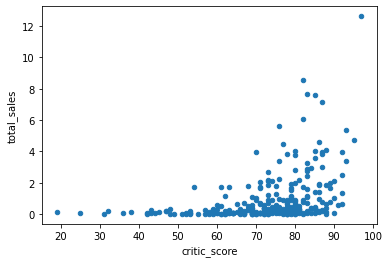

In [53]:
ps4 = df_actual.query('platform == "PS4"').copy()
ps4.dropna(subset = ['critic_score'], inplace = True) 
ps4.plot.scatter(x = 'critic_score', y = 'total_sales');

In [54]:
ps4[['critic_score','total_sales']].corr()

,critic_score,total_sales
critic_score,1.000000,0.392101
total_sales,0.392101,1.000000


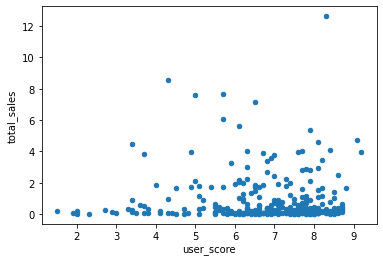

In [55]:
ps4 = df_actual.query('platform == "PS4"').copy()
ps4.dropna(subset = ['user_score'], inplace = True) 
ps4.plot.scatter(x = 'user_score', y = 'total_sales');

In [56]:
ps4[['user_score','total_sales']].corr()

,user_score,total_sales
user_score,1.000000,-0.020383
total_sales,-0.020383,1.000000


По графикам и матрице корреляции видно, что для платформы PS4 зависимость между продажами и отзывами критиков положительная и слабая, между продажами и отзывами пользователей - отрицательная и очень слабая

- Соотнесите выводы с продажами игр на других платформах.


Построим диаграммы рассеяния для остальных платформ между продажами и пользовательской оценкой и оценкой критиков

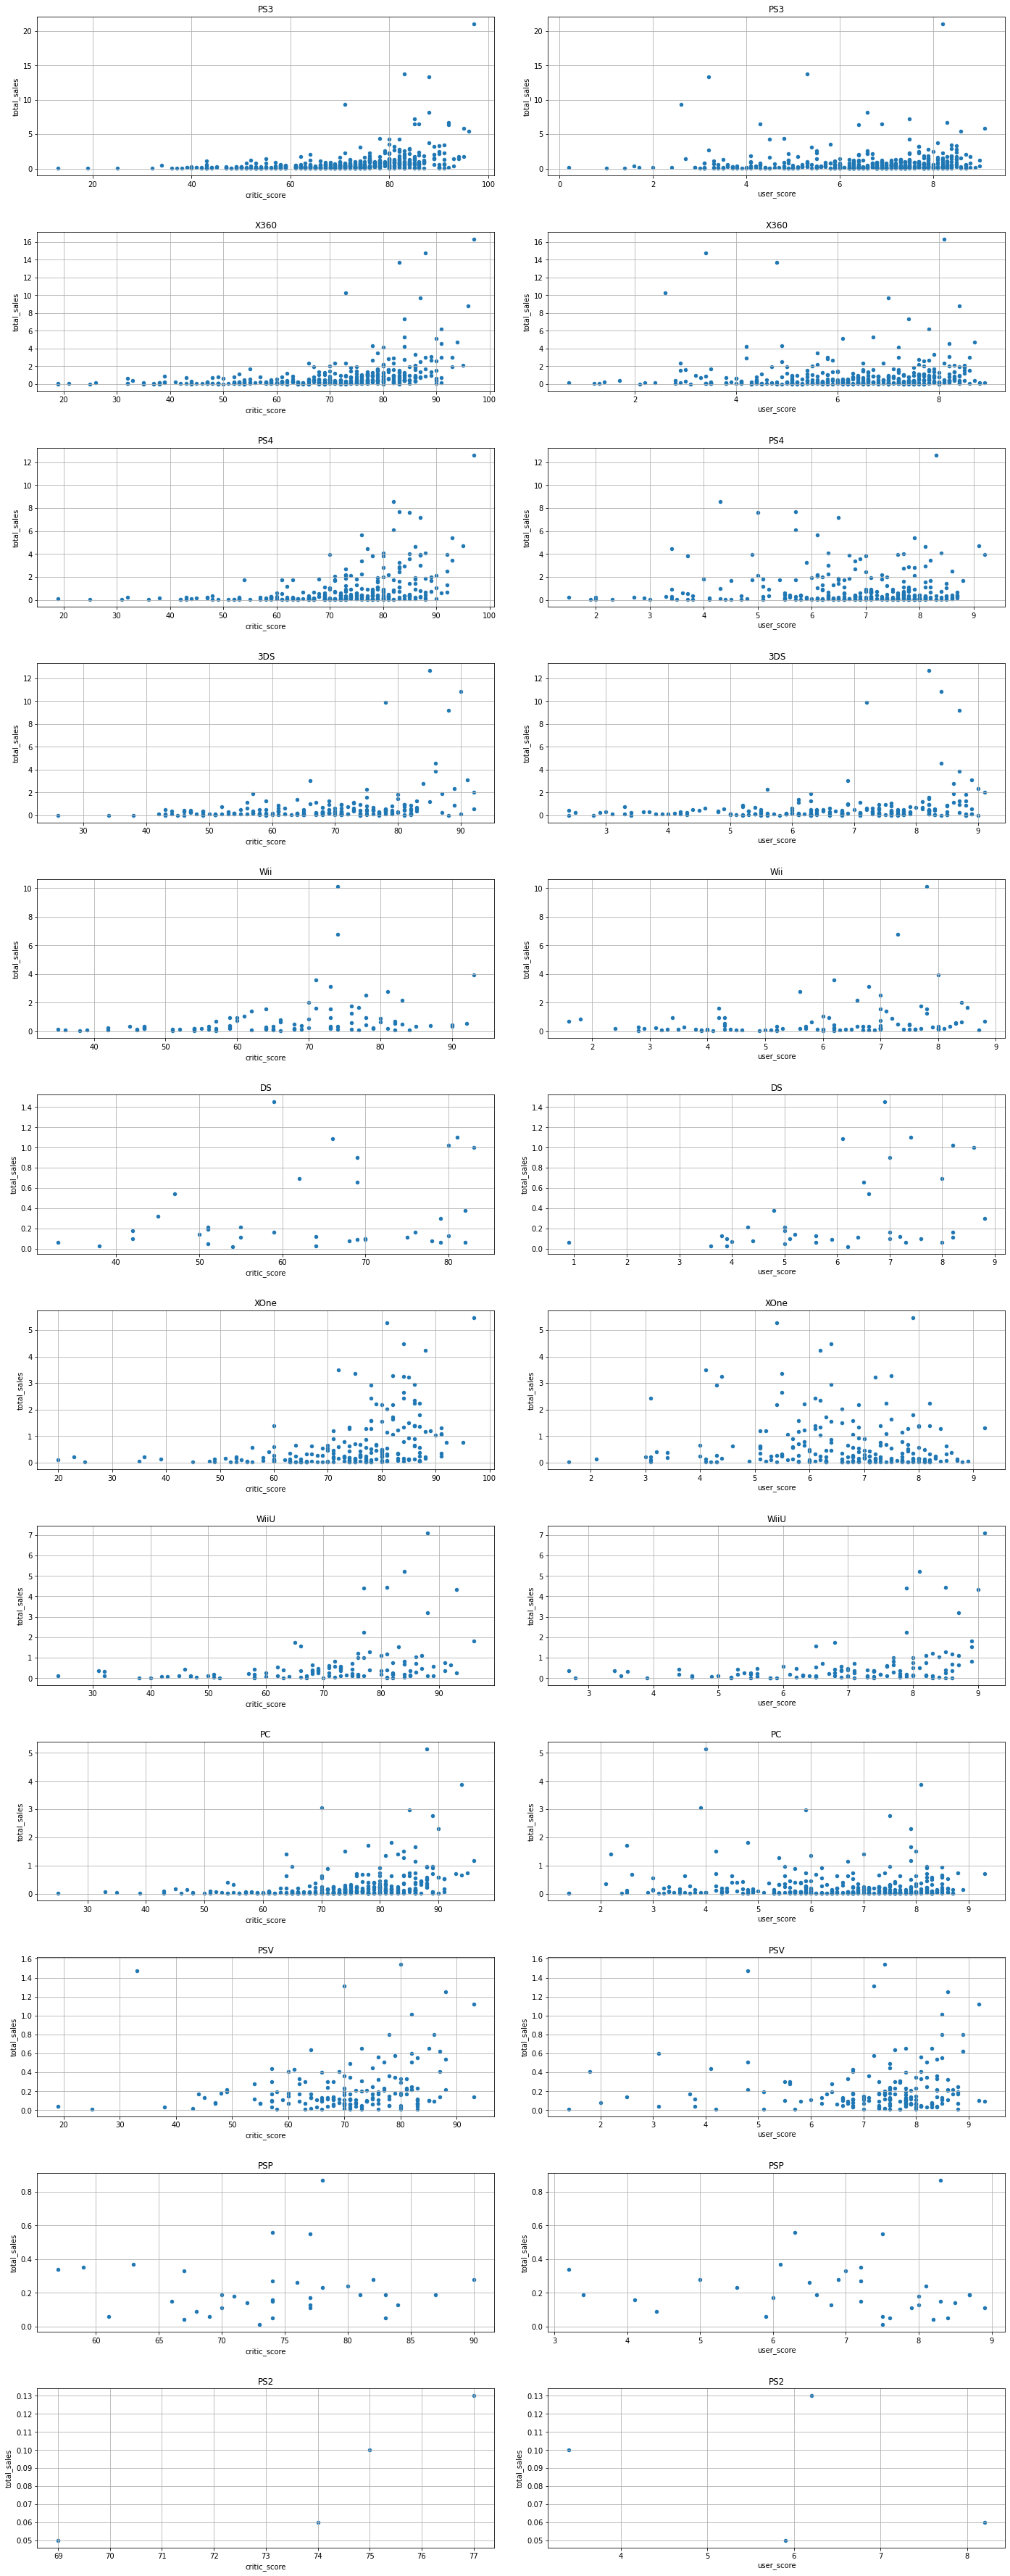

In [57]:
platforms = df_actual['platform'].unique()
qty_platforms = len(platforms)
fig, axes = plt.subplots(nrows=qty_platforms, ncols=2, figsize=(20,50))
i = 0
j = 0
for platform in platforms:
    platform_data_critic = df_actual.query('platform == @platform').copy()
    platform_data_critic.dropna(subset = ['critic_score'], inplace = True) 
    platform_data_critic.plot(kind = 'scatter', x = 'critic_score',y = 'total_sales', title = platform, grid = True,  ax = axes[i,j]);
    ax.set_xlabel('critic_score')
    j += 1
    platform_data_user = df_actual.query('platform == @platform').copy()
    platform_data_user.dropna(subset = ['user_score'], inplace = True) 
    platform_data_user.plot(kind = 'scatter', x = 'user_score',y = 'total_sales', title = platform, grid = True,  ax = axes[i,j]);
    ax.set_xlabel('user_score')
    i += 1
    j -= 1
    fig.tight_layout(pad=3.0)

Построим матрицу корреляции для остальных платформ между продажами и пользовательской оценкой 

In [58]:
platform_data_user = df_actual.copy()
platform_data_user.dropna(subset = ['user_score'], inplace = True) 
platform_data_user.groupby('platform')['user_score','total_sales'].corr()

C:\Users\nikotyan\PycharmProjects\yandex_project_2_property\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


user_score  total_sales
platform                                     
3DS      user_score     1.000000     0.232028
         total_sales    0.232028     1.000000
DS       user_score     1.000000     0.404446
         total_sales    0.404446     1.000000
PC       user_score     1.000000    -0.047506
         total_sales   -0.047506     1.000000
PS2      user_score     1.000000    -0.373270
         total_sales   -0.373270     1.000000
PS3      user_score     1.000000     0.030837
         total_sales    0.030837     1.000000
PS4      user_score     1.000000    -0.020383
         total_sales   -0.020383     1.000000
PSP      user_score     1.000000    -0.063369
         total_sales   -0.063369     1.000000
PSV      user_score     1.000000     0.059335
         total_sales    0.059335     1.000000
Wii      user_score     1.000000     0.220720
         total_sales    0.220720     1.000000
WiiU     user_score     1.000000     0.369594
         total_sales    0.369594     1.000000
X360     user_score     1.000000     0.048344
         total_sales    0.048344     1.000000
XOne     user_score     1.000000    -0.079942
         total_sales   -0.079942     1.000000

Построим матрицу корреляции для остальных платформ между продажами и оценкой критиков

In [59]:
platform_data_critic = df_actual.copy()
platform_data_critic.dropna(subset = ['critic_score'], inplace = True) 
platform_data_critic.groupby('platform')['critic_score','total_sales'].corr()

C:\Users\nikotyan\PycharmProjects\yandex_project_2_property\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


critic_score  total_sales
platform                                        
3DS      critic_score      1.000000     0.325074
         total_sales       0.325074     1.000000
DS       critic_score      1.000000     0.258084
         total_sales       0.258084     1.000000
PC       critic_score      1.000000     0.309252
         total_sales       0.309252     1.000000
PS2      critic_score      1.000000     0.861022
         total_sales       0.861022     1.000000
PS3      critic_score      1.000000     0.353166
         total_sales       0.353166     1.000000
PS4      critic_score      1.000000     0.392101
         total_sales       0.392101     1.000000
PSP      critic_score      1.000000     0.030184
         total_sales       0.030184     1.000000
PSV      critic_score      1.000000     0.175562
         total_sales       0.175562     1.000000
Wii      critic_score      1.000000     0.280507
         total_sales       0.280507     1.000000
WiiU     critic_score      1.000000     0.327594
         total_sales       0.327594     1.000000
X360     critic_score      1.000000     0.367364
         total_sales       0.367364     1.000000
XOne     critic_score      1.000000     0.381923
         total_sales       0.381923     1.000000

В среднем для всех платформ корреляция между продажами и оценкой критиков слабая. Только для одной платформы PS2 - она очень высокая, это связано с тем, что у нас очень мало игр на ней.  Корреляция между продажами и оценкой пользователей тоже слабая и она меньше чем между оценкйо критиков и продажами. При этом по графикам видно, что крреляция между маленькими продажами и низкими оценками есть, а между высокими оценками и продажами - нет

- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Посмотрим в каких жанрах игр больше всего, в каких - меньше

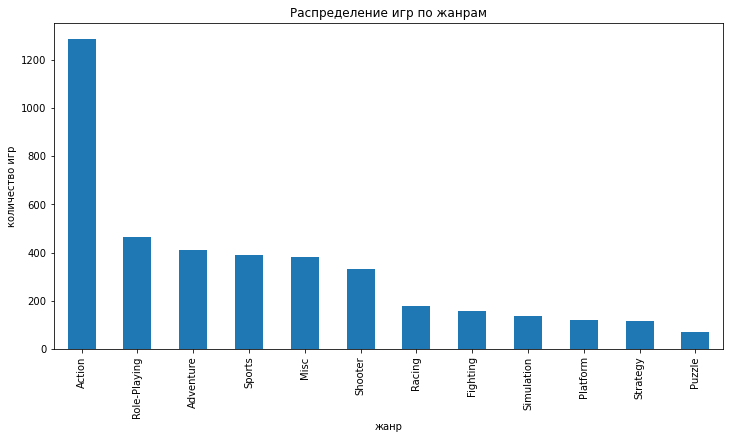

In [60]:
games_qty_by_genres = df_actual['genre'].value_counts()
ax = games_qty_by_genres.plot(kind ='bar',figsize = (12,6), title = 'Распределение игр по жанрам');
ax.set_xlabel('жанр');
ax.set_ylabel('количество игр');

Больше всего игр в жанре action. Вторе и третье место по количеству игр занимают жанры role-playing. adventure sports. Меньше всего игр в жанрах - platform, strategy, puzzle

Создадим сводную таблицу по жанрам и продажам. Посмотрим продажи по жанрам

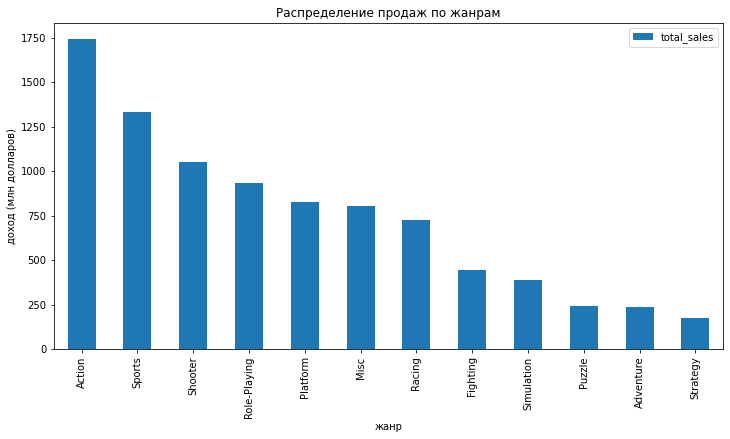

In [61]:
df_by_genre_sales = df.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum')
ax = df_by_genre_sales.sort_values(by = 'total_sales',ascending = False).plot(kind ='bar',figsize = (12,6), title = 'Распределение продаж по жанрам');
ax.set_xlabel('жанр');
ax.set_ylabel('доход (млн долларов)');

Посмотрим описательные статистики по продажам

In [62]:
df_by_genre_sales.describe()

,total_sales
count,12.000000
mean,742.774167
std,479.876035
min,174.230000
25%,353.120000
50%,765.590000
75%,964.032500
max,1744.170000


Больше всего прибыли принесли игры в жанрах action, sports, shooter. Меньше всего - puzzle, adventure, strategy. Скорее всего это связано с тем, что приключения, стратегии и паззлы - нединамичные устаревшие жанры, в которых медленно развиваются события. Людям интереснее играть в игры "более динамичных" жанров . Можем сказать, что жанры с продажами менее 350 млн долларов - жанры, которые плохо продаются и свыше 964 - те, что пользуются спросом

### Вывод

- Выяснили, что самые продаваемые игры с годом выпуска больше 2001 и среднее время смены одной платформы на другую 5 лет. Сделали вывод, что для дальнейшего анализа нам достаточно взять данные -5 лет, т.е. с 2011 года
- Узнали, что продажи по платформам PS3, X360 растут, а по платформам - 3DS, PC,PSV,  WiiU, - падают. При этом они падают меньше 4 лет, так что в следующим году эти платформы скорее всего будут еще актуальны
- Самые высоие медиана по продажам у плаформы PS4, самая низкая - у PS2. У платформы Wii есть выброс сверху, у платфомы WiiU - выброс снизу. Самы большой разброс значений у платформы PS3, самый низкий - PS2
- В среднем для всех платформ корреляция между продажами и оценкой критиков слабая. Только для одной платформы PS2 - она очень высокая, это связано с тем, что у нас очень мало игр на ней.  Корреляция между продажами и оценкой пользователей тоже слабая и она меньше чем между оценкйо критиков и продажами. При этом корреляция между маленькими продажами и низкими оценками есть, а между высокими оценками и продажами - нет
- Больше всего прибыли принесли игры в жанрах action, sports, shooter. Меньше всего - puzzle, adventure, strategy. Скорее всего это связано с тем, что приключения, стратегии и паззлы - нединамичные устаревшие жанры, в которых медленно развиваются события. Людям интереснее играть в игры "более динамичных" жанров .

### <a id="step4">Шаг 4. Составьте портрет пользователя каждого региона</a>

- Определите для пользователя каждого региона (NA, EU, JP):
Самые популярные платформы (топ-5). Опишите различия в долях продаж.
Самые популярные жанры (топ-5). Поясните разницу.

Найти топ-5 платформ и топ-5 жанров в каждом регионе - схожие задачи. Напишем общую функцию для их решения.
Напишем функцию, которая для каждого региона:
- выбирает верхний квантиль по продажам
- в выбранных данных находит топ-5 по признаку, который мы передадим как аргумент
- строит график зависимости продаж от параметра для топ-5

In [63]:
def show_plots_top_param_by_region(data, param):
    regions = ['na_sales', 'eu_sales', 'jp_sales']
    dict = ({'na_sales':'Северная Америка', 'eu_sales':'Европа', 'jp_sales':'Япония'})
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    if param == 'platform':
        title = 'платформам'
        xlab = 'платформы'
    else:
        title = 'жанрам'
        xlab = 'жанры'        
    fig.suptitle('Количество продаж по '+title+' в разных регионах', fontsize=16)
    i = 0
    for region in regions:
        quantile_75 = data[region].quantile(0.75)
        top_sales = data.loc[df[region] >= quantile_75]
        top_group_by_param = top_sales.groupby(param)[region].sum().sort_values(ascending = False).head()
        region_title = dict.get(region)
        top_group_by_param.plot(kind = 'bar', ax = axes[i], title = region_title);
        axes[i].set_xlabel(xlab)
        axes[i].set_ylabel('продажи')
        i += 1

Построим графики для платформ


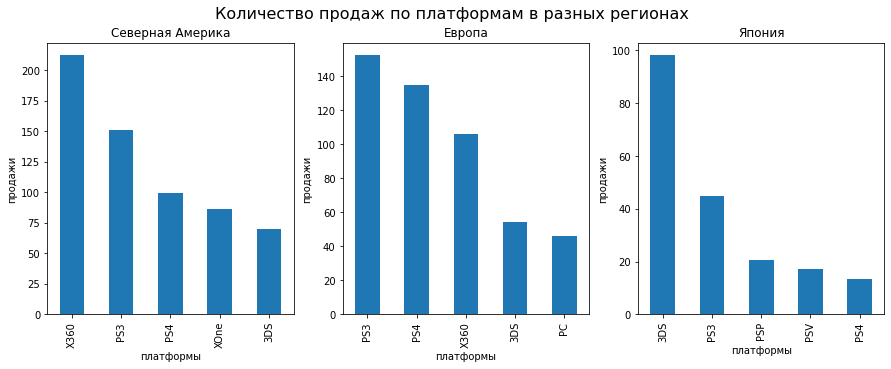

In [64]:
show_plots_top_param_by_region(df_actual, 'platform')

У нас получился следующий топ - платформ:
- Америка: X360, PS3, PS4, XOne, 3DS
- Европа: PS3, PS4, X360, 3DS, PC
- Япония: 3DS, PS3, PSP, PSV, PS4 

При этом есть особенные именно для этого региона платформы:  
- В Америке в топ входит платформа XOne, которая не входит в топ для других регионов. 
- В Европе в топ входит платформа PC, которая не входит в топ для других регионоа
- В Японии в топ вхоят платформы PSP, PSV, которые не входят в топ для других регионов

Посмотрим доли продаж по разным регионам для разных платформ

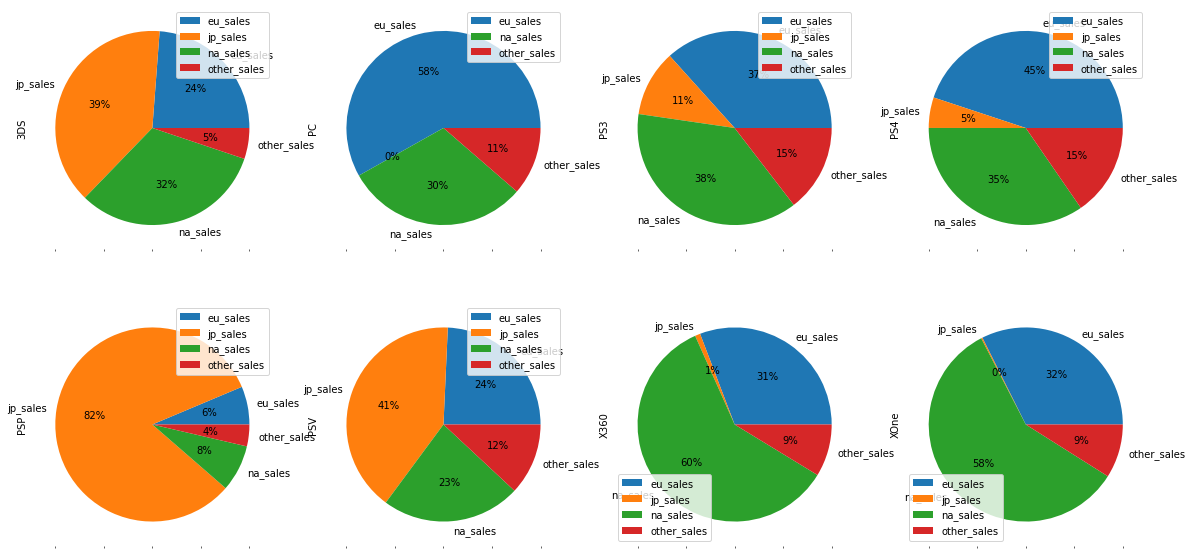

In [65]:
platforms = ['X360','PSP','PS3','PSV','3DS','PS4','XOne','PC','PSP']
pivot_table_patform = df_actual.query('platform in @platforms').pivot_table(index = 'platform', values = ['na_sales', 'eu_sales', 'jp_sales','other_sales'], aggfunc = 'sum').T
ax = pivot_table_patform.plot(kind = 'pie',subplots=True, figsize=(20, 10),autopct='%1.0f%%', layout = (2,4));



Япония занимает лидирующую долю в продажах игр на платформах -  PSP, 3DS, PSV. Можно сделать вывод, что в Японии популярны платформы фирм Sony, Nintendo. И это не удивительно, т.к. Nintendo, Sony - японскии компании, 
Европа занимает лидирующую долю в продажах игр на платформах -  PC, PS4. 
Северная Америка занимает лидирующую долю в продажах игр на платформах - PS3, X360, XOne. Можно сделать вывод, что в Америке популярны игры компаний Microsoft и Sony

- Самые популярные жанры (топ-5). Поясните разницу.


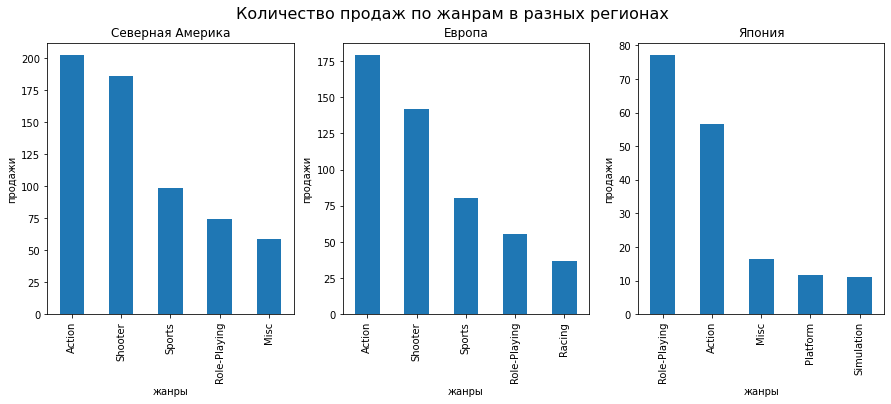

In [66]:
show_plots_top_param_by_region(df_actual, 'genre')

Получился следующий топ жанров:  
- Америка: action, shooter, sports, role-playing, misc  
- Европа: action, shooter, sports, role-playing, racing
- Япония: role-playing, action, misc, platform, sumilation.  

В Японии популярны портативные приставки, где в основном игры платоформеры и симуляторы, поэтому они вошли в топ. В остальом топ не сильно отличается дл яразных регионов

- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Посотроим матрицу корелляции

Построим марицу рассеяния

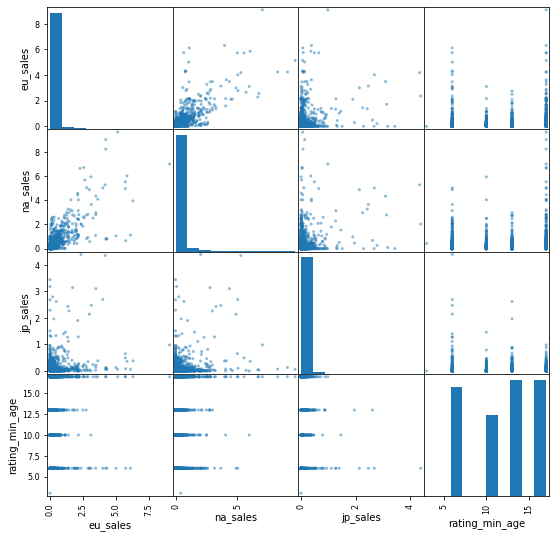

In [67]:
df_rating_sales = df_actual[['eu_sales','na_sales','jp_sales','rating_min_age']]
pd.plotting.scatter_matrix(df_rating_sales, figsize = (9,9));

In [68]:
print(df_rating_sales.corr());

                eu_sales  na_sales  jp_sales  rating_min_age
eu_sales        1.000000  0.779753  0.278448        0.093877
na_sales        0.779753  1.000000  0.273692        0.093267
jp_sales        0.278448  0.273692  1.000000       -0.020596
rating_min_age  0.093877  0.093267 -0.020596        1.000000


Зависимость между рейтингом и продажами слабая. Видно. что я Японии есть популярность игр для младшего возраста, в Америке же - для взрослых

### Вывод

У нас получился следующие портреты пользователей:
- Америка. Популярные платформы: X360, PS3, PS4, XOne, 3DS. В топ входит платформа XOne, которая не входит в топ для других регионов. Это платформа фирмы Mirosoft, американской компании, поэтому может быть она так популярна на родине. Топ жанров: action, shooter, sports, role-playing, misc. Популярны игры с рейтингом ESRB 18+
- Европа: Популярные платформы: PS3, PS4, X360, 3DS, PC. Европа занимает лидирующую долю в продажах игр на платформах -  PC, PS4. Топ жанров: action, shooter, sports, role-playing, racing
- Япония: Популярные платформы: 3DS, PS3, PSP, PSV, PS4. В Японии в топ вхоят платформы PSP, PSV, которые не входят в топ для других регионов. Япония занимает лидирующую долю в продажах игр на платформах -  PSP, 3DS, PSV. Можно сделать вывод, что в Японии популярны платформы фирм Sony, Nintendo. И это не удивительно, т.к. Nintendo, Sony - японскии компании. Топ жанров: role-playing, action, misc, platform, sumilation. В Японии популярны портативные приставки, где в основном игры платоформеры и симуляторы, поэтому они вошли в топ. В остальом топ не сильно отличается для разных регионов. В Японии популярны игры для младшего возраста

Зависимость между рейтингом ESRB и продажами слабая

### <a id="step5">Шаг 5. Проверка гипотез</a>

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;


Выдвинем следующие гипотезы:
- Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC не равны

Создадим выборки для платформ Xbox One и PC

In [69]:
xbox_one_df = df_actual.query('platform == "XOne"')['user_score']
pc_df = df_actual.query('platform == "PC"')['user_score']

Для того, чтобы понять какой тест можем использовать, нам нужно проверить наши распределения на нормальность. Воспользуемся критерием Шапиро

In [70]:
from scipy.stats import shapiro
print(shapiro(pc_df.dropna()))
print(shapiro(xbox_one_df.dropna()))

(0.9408451914787292, 5.261505120479626e-10)
(0.9504857063293457, 1.5265110278050997e-06)


Мы получили слишком малое p-value < 0.05 не можем использовать t-test

Зададим критический уровень значимости равный 0.05. При проверки будем использовать критерий Манна Уитни для сравнения средних двух генеральных совокупностей. 

In [71]:
alpha = .05

results = st.mannwhitneyu(
    xbox_one_df.dropna(), 
    pc_df.dropna())

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4283856304517803
Не получилось отвергнуть нулевую гипотезу


В результате проверки получилось, что p-value больше чем критический уровень значимости. Отсюда следует, что при выбранном уровне значимости в 0.05 мы не можем отвергнуть нулевую гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые

- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Выдвинем следующие гипотезы:
- Нулевая гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.
- Альтернативная гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Создадим выборки для жанров action, sports

In [72]:
action_df = df_actual.query('genre == "Action"')['user_score']
sports_df = df_actual.query('genre == "Sports"')['user_score']

Для того, чтобы понять какой тест можем использовать, нам нужно проверить наши распределения на нормальность. Воспользуемся критерием Шапиро

In [73]:
from scipy.stats import shapiro
print(shapiro(action_df.dropna()))
print(shapiro(sports_df.dropna()))

(0.9322226643562317, 2.4995092345395005e-18)
(0.9581581354141235, 2.322995555914531e-07)


Мы получили слишком малое p-value < 0.05 не можем использовать t-test

Зададим критический уровень значимости равный 0.05. При проверки будем использовать критерий Манна Уитни для сравнения средних двух генеральных совокупностей. 

In [74]:
alpha = .05

results = st.mannwhitneyu(
    action_df.dropna(), 
    sports_df.dropna())

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.926793604198302e-25
Отвергаем нулевую гипотезу


В результате проверки получилось, что p-value меньше чем критический уровеь значимости. Отсюда следует, что мы отвергаем нулевую гипотезу.Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Вывод

Проверили гипотезы. Можем следлать следующие выводы:
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
- При выбранном уровне значимости в 0.05 мы не можем отвергнуть гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые

### <a id="step6">Шаг 6. Общий вывод</a>

В проекте проанализировали данные о продажах игр, оценке пользователей и экспертов, жанрах и платформах с с целью выявить закономерности, определяющие успешность игры, чтобы спланировать продажи на 2017 год и понять каков принцип работы с данными для планирования продаж в следующих годов.
Обработали пропуски и удалили дубликаты, чтобы получить более информатичные данные. 

При планировании продаж на 2017 год нам стоит обратить внимание на следующие моменты:
- Обратить внимание на игры на платформы PS3, X360. Продажи по ним растут и еще не прошло 5 лет с их появления, так что в дальнейшем скорее всего они будут популярны
- Не брать в продажу игры с низкой оценкой пользователей и критиков, по ним будут низкие продажи
- При сегментировании рекламы стоит обратить внимание на следующие моменты:
    - Северная Америка. Популярные платформы: X360, PS3, PS4, XOne, 3DS. Топ жанров: action, shooter, sports. Популярны игры с рейтингом ESRB 18+
    - Европа: Популярные платформы: PS3, PS4, X360, 3DS, PC. Европа занимает лидирующую долю в продажах игр на платформах -  PC, PS4. Топ жанров: action, shooter, sports
    - Япония: Популярные платформы: 3DS, PS3, PSP, PSV, PS4. Топ жанров: role-playing, action, misc, platform, sumilation. В Японии популярны игры для младшего возраста


При планировании продаж в следущих годах нам стоит выявить следующие вещи:
- Взять данные за последние 10 лет. 
- Посмотреть какое время смены одной платформы на другую. В зависимости от этого времени отсечь ненужные данные.
- Выявить самые популярные платформы и те, по которым идет рост/спад в продажах и посмотреть сколько лет уже живет плафторма. В зависимости от этого можно сделать вывод стоит вкладывать в закупку игр на той или иной платформе. 
- Посмотреть какие жанры приносят больше всего прибыли, какие - меньше всего
- Просегментировать игры по регионам, составить топ-5 платформ, жанров по регионам. Посмотреть игр для какого возраста покупают больше втом или ином регионе. Просегментировать рекламу в зависимости от результата